# Advertiser Brand Index

---
## API SETUP:
---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import cachetools, requests, urllib
import os, json, time, datetime, dateutil, calendar, itertools
import warnings
warnings.filterwarnings("ignore") # dangerous
plt.style.use(['seaborn-dark-palette'])
%matplotlib inline

In [2]:
API_BASE = 'https://api.brandindex.com/v0/'
API_HEAD = {'Accept':'application/json'}

def jprint(x, n = 500):
    'Pretty print some json with truncation.'
    print(json.dumps(x, sort_keys = True, indent = '\t')[:n])

def auth():
    user = 'removed'
    key = 'removed'
    return requests.post(API_BASE + 'login', data = {'email':user, 'password':key}).cookies

@cachetools.func.ttl_cache(ttl=600)
def yget(urlfrag):
    'Returns a json object of YouGov data for a url fragment.'
    return requests.get(API_BASE + urlfrag, headers = API_HEAD, cookies = auth()).json()

In [5]:
yget('filters/demos?region=us')['data']['bixdemo_ageall']

{'1': '18-24',
 '2': '25-34',
 '3': '35-44',
 '4': '45-54',
 '5': '55-64',
 '6': '65+'}

In [6]:
print([x['name'] for x in yget('company/brands?region=us&sector=7')['data'].values()])

['Hummer', 'Fiat', 'Chrysler', 'Kia', 'Jeep', 'Lexus', 'BMW', 'Chevrolet', 'General Motors', 'Infiniti', 'Dodge', 'Honda', 'Acura', 'Volkswagen', 'Hyundai', 'Tesla', 'Advertiser', 'Lincoln', 'Nissan', 'Subaru', 'Mercury', 'Toyota', 'Mazda', 'Buick', 'Mitsubishi', 'Audi', 'Saturn', 'Pontiac', 'Cadillac', 'Mercedes', 'GMC', 'Volvo', 'Ford']


In [7]:
def advertiserdat(startdate = '2014-01-01', enddate = str(datetime.date.today() - datetime.timedelta(days = 5))):
    base = 'timeline/file.json?'
    sectorq = 'sector=%s' % 7 # 'Car Makers'
    brandq = '&brand_id=%s' % removed # 'Advertiser'
    startq = '&start_date=%s' % startdate
    endq = '&end_date=%s' % enddate
    calcq = '&moving_average=1&scoring=total&region=us'
    demoq = '&filters=:bixdemo_ageall.2%2C3%2C4%2C5%2C6'
    query = (base + sectorq + brandq + startq + endq + calcq + demoq)
    print(query)
    return yget(query)

In [8]:
def todf(jdat):
    colbase = ['aided','adaware','impression','consider']
    cols = ['datebin'] + [x + '_score' for x in colbase] + [x + '_volume' for x in colbase]
    odat = []
    for dt, jdat2 in jdat.items():
        odat += [[dt] + [jdat2[x]['score'] for x in colbase] + [jdat2[x]['volume'] for x in colbase]]
    df = pd.DataFrame(odat, columns = cols)
    df.datebin = pd.to_datetime(df.datebin)
    df = df.sort_values('datebin').reset_index(drop = True)
    df.set_index('datebin', inplace = True)
    df['t'] = np.arange(df.shape[0])
    if np.isnan(df.ix[-1,0]):
        df = df.iloc[:-1,:]
    return df

In [10]:
df = todf(dat)
df.head(2)

,aided_score,adaware_score,impression_score,consider_score,aided_volume,adaware_volume,impression_volume,consider_volume,t
datebin,,,,,,,,,
2014-01-01,65.416725,3.876053,16.614862,3.999096,79.131505,79.131505,79.131505,79.131505,0
2014-01-02,65.022148,3.810484,3.879191,3.810484,78.107841,78.107841,78.107841,78.107841,1


In [11]:
df.tail(2)

,aided_score,adaware_score,impression_score,consider_score,aided_volume,adaware_volume,impression_volume,consider_volume,t
datebin,,,,,,,,,
2016-09-14,72.685040,4.805496,-4.557240,1.548195,93.827984,93.827984,93.827984,93.827984,987
2016-09-15,77.469199,5.738527,-0.035989,3.864721,84.725536,84.725536,84.725536,84.725536,988


In [12]:
df.describe()

,aided_score,adaware_score,impression_score,consider_score,aided_volume,adaware_volume,impression_volume,consider_volume,t
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,69.892080,7.133974,4.772182,3.424386,91.671648,91.671648,91.669208,91.671648,494.000000
std,5.597507,3.346651,4.734912,2.080948,12.778420,12.778420,12.781457,12.778420,285.644009
min,51.244667,0.000000,-13.169640,0.000000,21.585533,21.585533,21.585533,21.585533,0.000000
25%,65.977085,4.637018,1.659454,1.877339,82.700937,82.700937,82.700937,82.700937,247.000000
50%,70.222996,6.725989,4.701973,3.161562,91.525148,91.525148,91.525148,91.525148,494.000000
75%,73.725026,9.271265,7.688726,4.670406,100.302138,100.302138,100.302138,100.302138,741.000000
max,87.924589,22.615517,20.094151,13.552384,155.279568,155.279568,155.279568,155.279568,988.000000


In [13]:
# Sample size (thousands):
round(df['2016-08-01':'2016-08-31'].adaware_volume.sum()/1000,1)

3.2

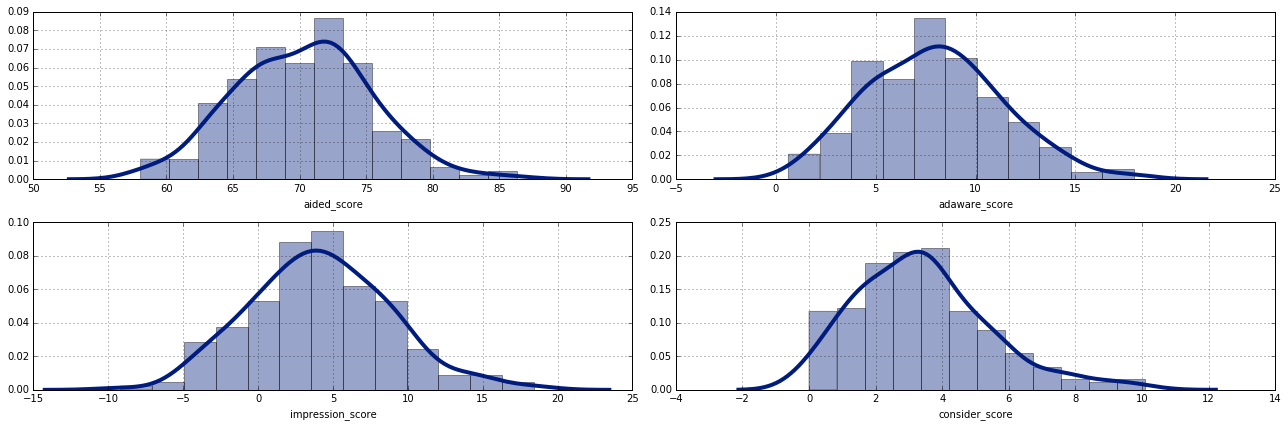

In [14]:
slc = slice('2016-01-01','2016-07-31')
fig, ax = plt.subplots(2, 2, figsize = (18, 6), sharex = False)
[ax[i,j].grid() for i, j in itertools.product((0,1),(0,1))]
sns.distplot(df[slc].aided_score, hist = True, ax = ax[0,0], kde_kws = {'lw':4})
sns.distplot(df[slc].adaware_score, hist = True, ax = ax[0,1], kde_kws = {'lw':4})
sns.distplot(df[slc].impression_score, hist = True, ax = ax[1,0], kde_kws = {'lw':4})
sns.distplot(df[slc].consider_score, hist = True, ax = ax[1,1], kde_kws = {'lw':4})
plt.tight_layout();

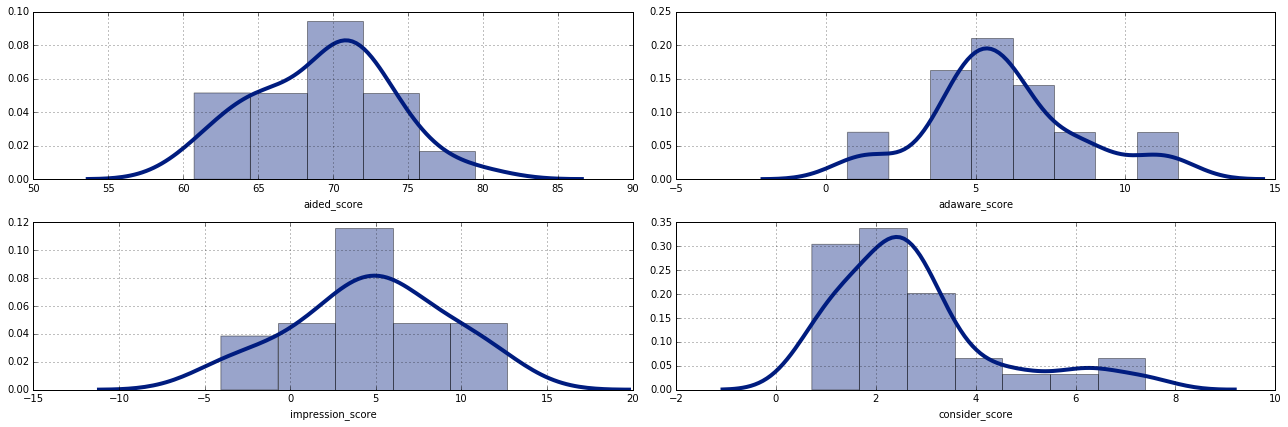

In [15]:
slc = slice('2016-08-01','2016-08-31')
fig, ax = plt.subplots(2, 2, figsize = (18, 6), sharex = False)
[ax[i,j].grid() for i, j in itertools.product((0,1),(0,1))]
sns.distplot(df[slc].aided_score, hist = True, ax = ax[0,0], kde_kws = {'lw':4})
sns.distplot(df[slc].adaware_score, hist = True, ax = ax[0,1], kde_kws = {'lw':4})
sns.distplot(df[slc].impression_score, hist = True, ax = ax[1,0], kde_kws = {'lw':4})
sns.distplot(df[slc].consider_score, hist = True, ax = ax[1,1], kde_kws = {'lw':4})
plt.tight_layout();

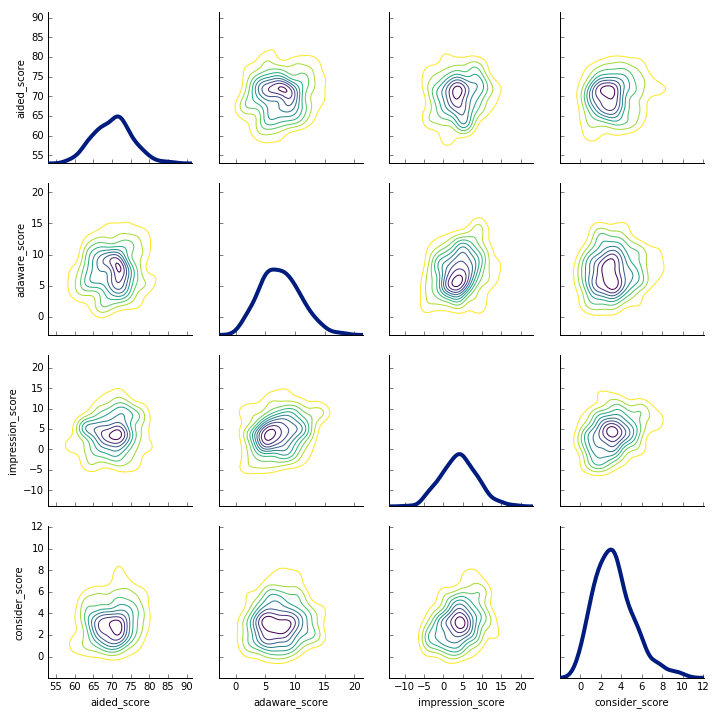

In [16]:
sns.PairGrid(df['2016-01-01':].ix[:, 0:4]).map_diag(sns.kdeplot, lw = 4).map_offdiag(sns.kdeplot, lw = 4, cmap='viridis_r', n_levels=10);

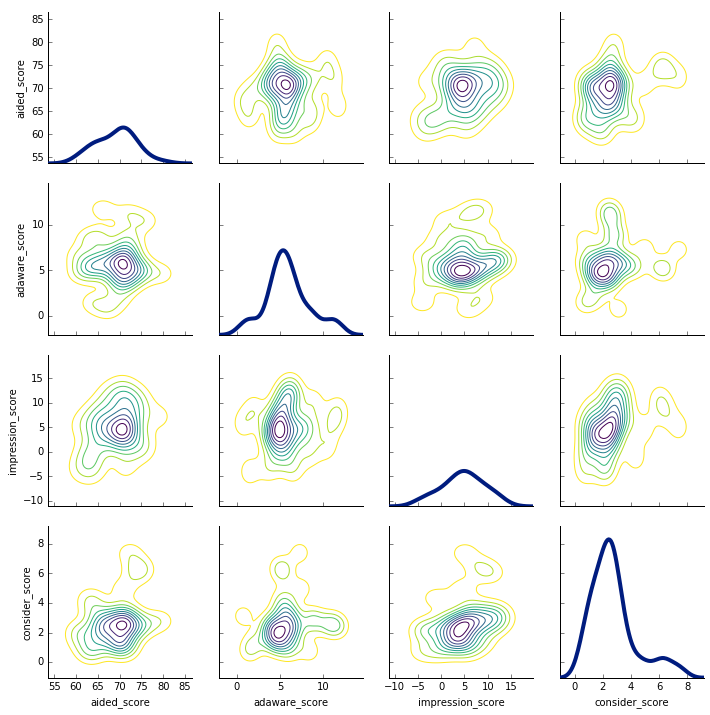

In [17]:
sns.PairGrid(df['2016-08-01':'2016-08-31'].ix[:, 0:4]).map_diag(sns.kdeplot, lw = 4).map_offdiag(sns.kdeplot, cmap='viridis_r', n_levels=10);

In [18]:
def plotdf(df, colname, title, ylim = None, figsz = (25,4)):
    df[colname].plot(grid = True, figsize = figsz, title = title, color = '#444444', legend = True, ylim = ylim, lw = 1)
    df[colname].rolling(center = False, window = 7).mean().plot(grid = True, figsize = figsz, lw = 2, color = '#442200', label = '7dma', legend = True)
    df[colname].rolling(center = False, window = 30).mean().plot(grid = True, figsize = figsz, lw = 2, color = '#002244', label = '30dma', legend = True)
    df[colname].rolling(center = False, window = 90).mean().plot(grid = True, figsize = figsz, lw = 2, color = '#0099FF', label = '90dma', legend = True)
    lsfit = scipy.stats.linregress(df.t, df[colname])
    if lsfit.pvalue < 0.05:
        print('Slope is non-zero')
    else:
        print('Slope is zero.')
    print(lsfit)
    (df.t * lsfit.slope + lsfit.intercept).plot(grid = True, figsize = figsz, lw = 3, color = '#FF9900', alpha = 0.9, label = 'ols', legend = True)
    res = statsmodels.formula.api.ols(colname + ' ~ t', data = df).fit()
    prstd, lc, uc = statsmodels.sandbox.regression.predstd.wls_prediction_std(res)
    uc.plot(grid = True, figsize = figsz, lw = 2, color = '#AA9900', alpha = 0.9, label = 'uc', legend = False, ls ='--')
    lc.plot(grid = True, figsize = figsz, lw = 2, color = '#AA9900', alpha = 0.9, label = 'lc', legend = False, ls ='--')
    plt.legend(loc = 'upper left')
    plt.show()

Slope is non-zero
LinregressResult(slope=0.0058849023877718693, intercept=67.880309609932098, rvalue=0.10765535416950132, pvalue=0.039813791627456963, stderr=0.0028524559980698228)


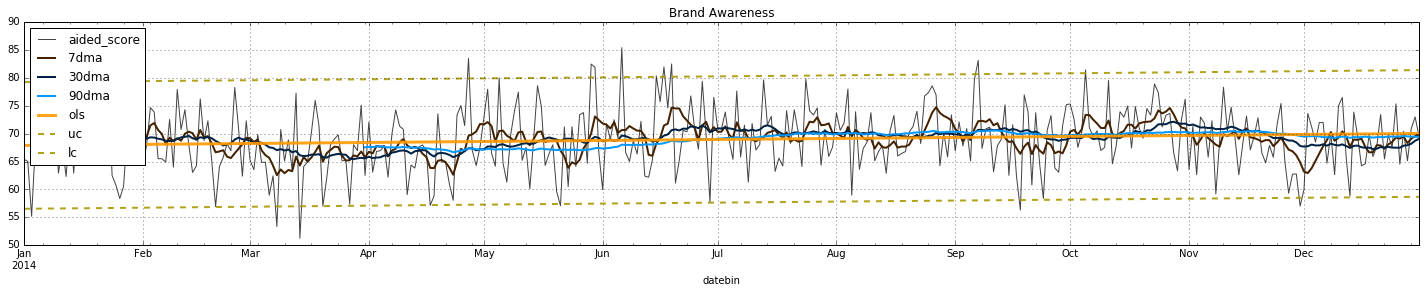

Slope is zero.
LinregressResult(slope=-0.0053863645324174828, intercept=73.50505520129127, rvalue=-0.10035865243862088, pvalue=0.055414561535820549, stderr=0.002802782796599213)


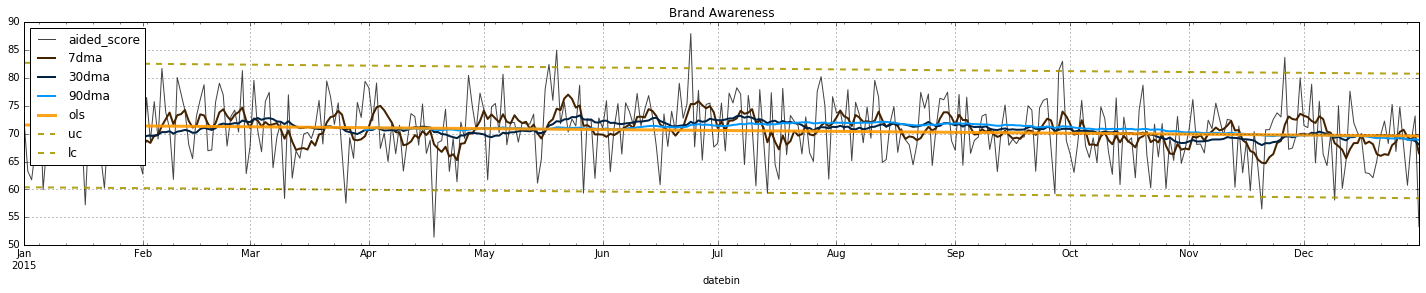

Slope is zero.
LinregressResult(slope=0.001773519237300061, intercept=68.754883024969672, rvalue=0.026167404090213394, pvalue=0.67509969973506734, stderr=0.0042262964993509356)


In [19]:
plotdf(df['2014-01-01':'2014-12-31'], 'aided_score', 'Brand Awareness', ylim = (50,90))
plotdf(df['2015-01-01':'2015-12-31'], 'aided_score', 'Brand Awareness', ylim = (50,90))
plotdf(df['2016-01-01':], 'aided_score', 'Brand Awareness', ylim = (50,90))

Slope is non-zero
LinregressResult(slope=-0.0059119779430839552, intercept=10.209299860894594, rvalue=-0.19479047343956837, pvalue=0.00018065810095569583, stderr=0.0015624715100775542)


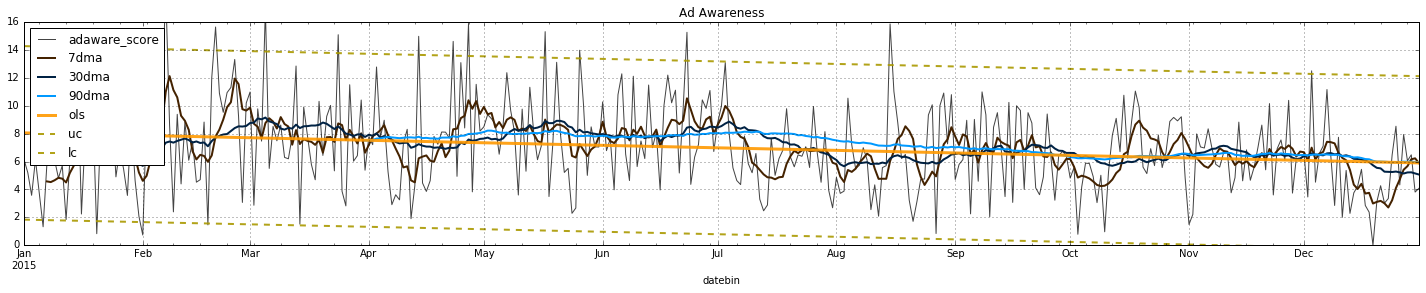

Slope is zero.
LinregressResult(slope=-0.0043374008172007367, intercept=11.272478788906321, rvalue=-0.097041671753872169, pvalue=0.11926579608971768, stderr=0.0027749179235228307)


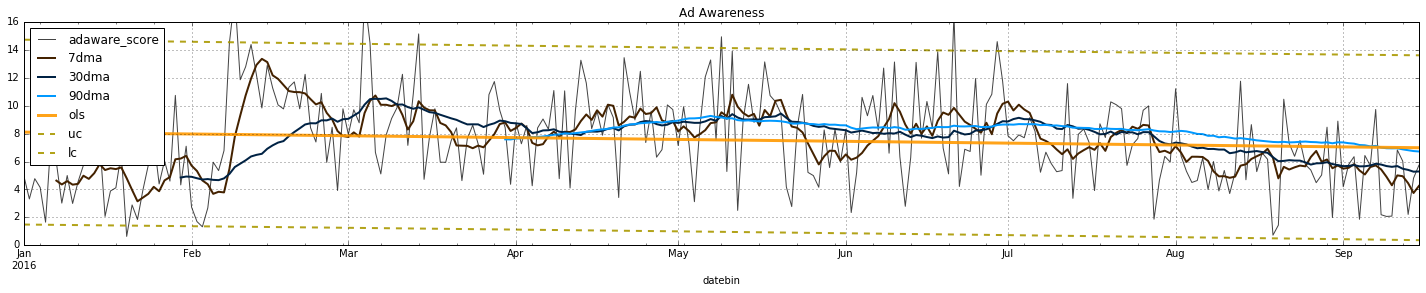

In [20]:
plotdf(df['2015-01-01':'2015-12-31'], 'adaware_score', 'Ad Awareness', ylim = (0,16))
plotdf(df['2016-01-01':], 'adaware_score', 'Ad Awareness', ylim = (0,16))

Slope is non-zero
LinregressResult(slope=-0.0018624423851116435, intercept=5.6922286551489938, rvalue=-0.11235595444390686, pvalue=0.00039988730408223636, stderr=0.00052428748500232467)


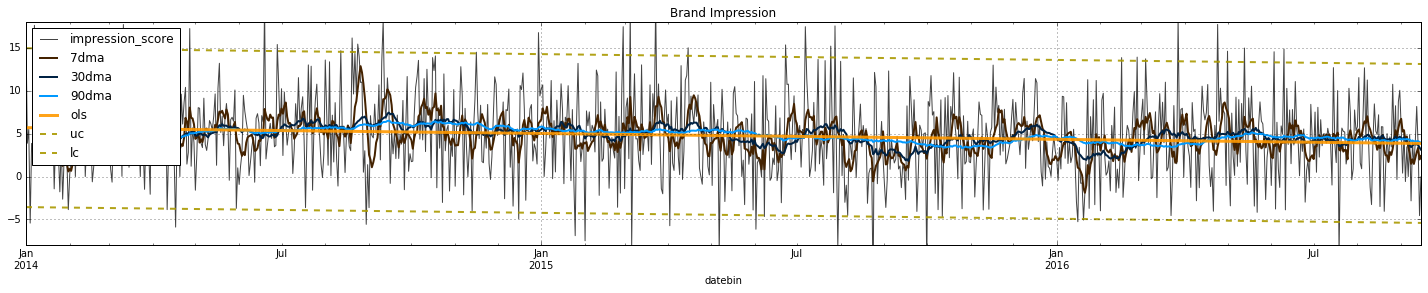

Slope is zero.
LinregressResult(slope=0.0029720047212259165, intercept=4.9540462883861975, rvalue=0.068706217196154398, pvalue=0.19030542867334929, stderr=0.002265023249945707)


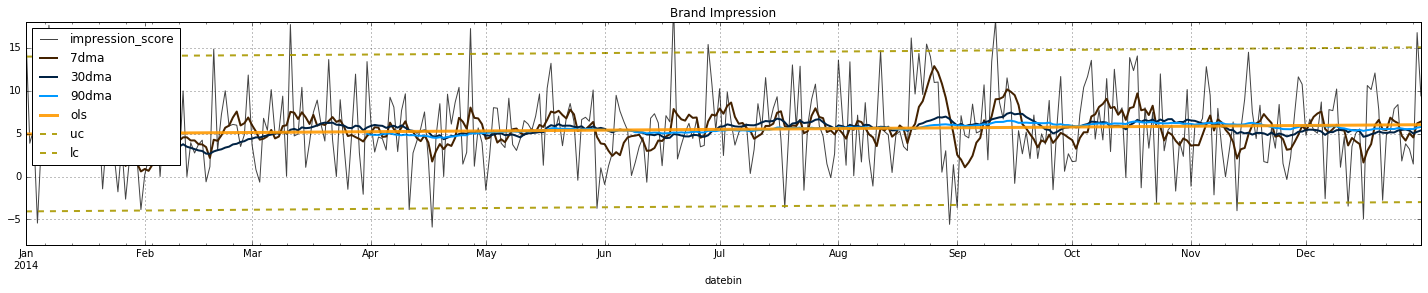

Slope is zero.
LinregressResult(slope=-0.003586592077960902, intercept=6.486334825805983, rvalue=-0.076829651470251129, pvalue=0.14293189949018295, stderr=0.0024429480720720934)


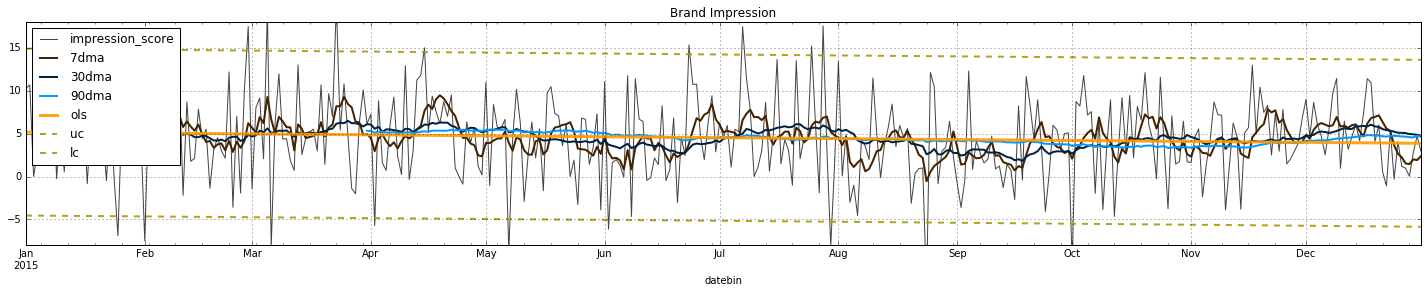

Slope is zero.
LinregressResult(slope=0.0018945316855764223, intercept=2.4752991146458374, rvalue=0.030998137541322929, pvalue=0.61948939174774087, stderr=0.0038105788864524317)


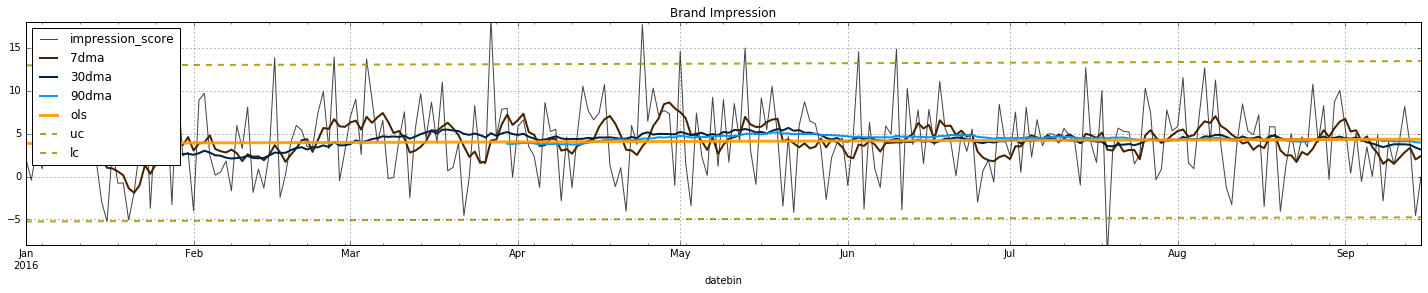

In [21]:
plotdf(df['2014-01-01':], 'impression_score', 'Brand Impression', ylim = (-8,18))
plotdf(df['2014-01-01':'2014-12-31'], 'impression_score', 'Brand Impression', ylim = (-8,18))
plotdf(df['2015-01-01':'2015-12-31'], 'impression_score', 'Brand Impression', ylim = (-8,18))
plotdf(df['2016-01-01':], 'impression_score', 'Brand Impression', ylim = (-8,18))

Slope is non-zero
LinregressResult(slope=-0.0033668100912210325, intercept=5.2287904918932471, rvalue=-0.16931123861232461, pvalue=0.0011660183702723417, stderr=0.0010286408094413342)


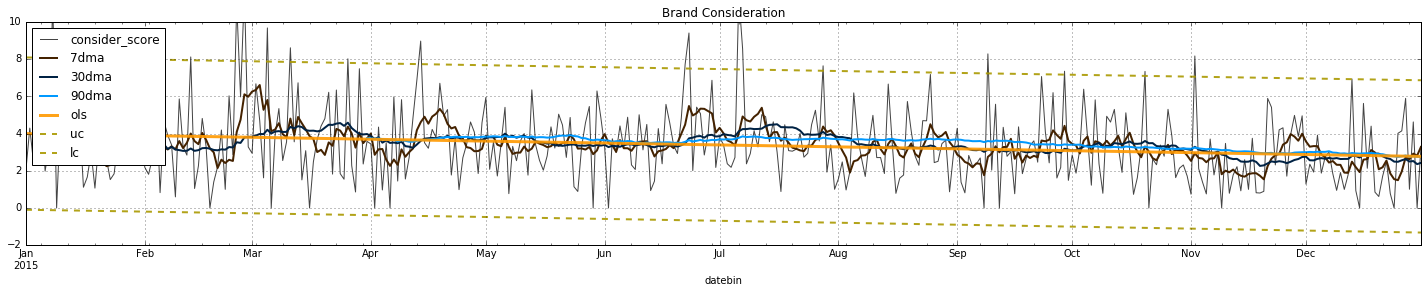

Slope is zero.
LinregressResult(slope=0.00064558027563229984, intercept=2.7760688157102322, rvalue=0.024764362969933253, pvalue=0.69160508227831241, stderr=0.001625636040005212)


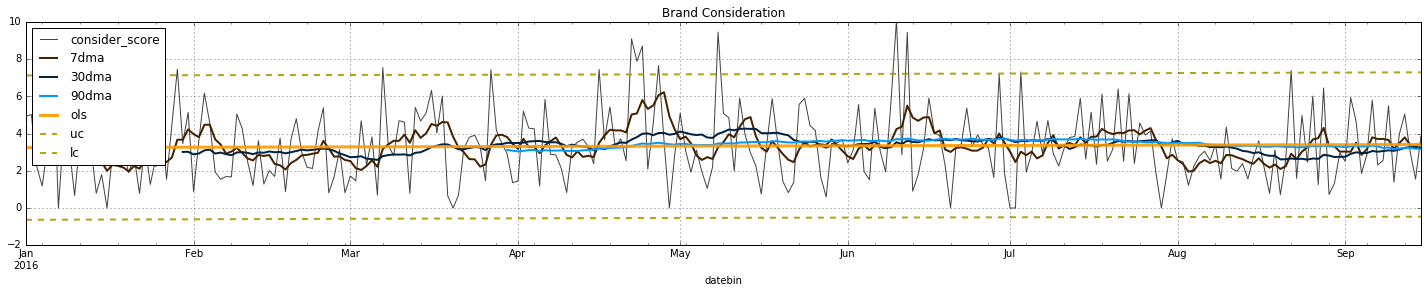

In [22]:
plotdf(df['2015-01-01':'2015-12-31'], 'consider_score', 'Brand Consideration', ylim = (-2,10))
plotdf(df['2016-01-01':], 'consider_score', 'Brand Consideration', ylim = (-2,10))

In [23]:
goals = {'aided':71.2, 'adaware':8.9, 'impression':4.6, 'consider':3.2}

In [30]:
def brandtracker(mo = datetime.date.today().month -1, yr = datetime.date.today().year):
    dftmp = pd.DataFrame(columns = ('metric', 'goal', 'actual_mo', 'actual_ytd',
                                    'actual_lmo', 'actual_ly', 'pct_goal', 'mom', 'yoy','vol_mo'))
    month_start = datetime.date(yr, mo, 1)
    month_end = datetime.date(yr, mo, calendar.monthrange(yr, mo)[1])
    lmo_start = datetime.date(yr, mo - 1, 1)
    lmo_end = datetime.date(yr, mo - 1, calendar.monthrange(yr, mo - 1)[1])
    year_start = datetime.date(yr, 1, 1)
    lyear_start = datetime.date(yr - 1, 1, 1)
    lyear_end = datetime.date(yr - 1, 12, 31)
    dfsl1 = df[month_start:month_end]
    dfsl2 = df[year_start:month_end]
    dfsl3 = df[lmo_start:lmo_end]
    dfsl4 = df[lyear_start:lyear_end]
    idx = 0
    for metric, goal in sorted(goals.items()):
        actual_mo = (dfsl1[metric + '_score'] * dfsl1[metric + '_volume']).sum() / dfsl1[metric + '_volume'].sum() 
        actual_ytd = (dfsl2[metric + '_score'] * dfsl2[metric + '_volume']).sum() / dfsl2[metric + '_volume'].sum()
        actual_lmo = (dfsl3[metric + '_score'] * dfsl3[metric + '_volume']).sum() / dfsl3[metric + '_volume'].sum()
        actual_ly = (dfsl4[metric + '_score'] * dfsl4[metric + '_volume']).sum() / dfsl4[metric + '_volume'].sum()
        pct_goal = 100 * actual_ytd / goal
        mom = 100 * (actual_mo - actual_lmo) / actual_lmo
        yoy = 100 * (actual_ytd - actual_ly) / actual_ly
        vol_mo = dfsl1[metric + '_volume'].sum()
        val = [metric, goal, actual_mo, actual_ytd, actual_lmo, actual_ly, pct_goal, mom, yoy, vol_mo]
        dftmp.loc[idx] = val
        idx += 1
    return dftmp.round(1)

In [31]:
brandtracker(8)

,metric,goal,actual_mo,actual_ytd,actual_lmo,actual_ly,pct_goal,mom,yoy,vol_mo
0,adaware,8.9,5.9,7.7,7.2,6.9,86.1,-18.7,10.3,3184.2
1,aided,71.2,69.3,70.1,71.4,70.5,98.4,-2.9,-0.6,3184.2
2,consider,3.2,2.7,3.3,3.4,3.4,102.8,-20.7,-2.0,3184.2
3,impression,4.6,4.7,4.2,4.1,4.5,91.2,15.2,-7.3,3184.2


In [ ]:
def plotdf_client(df, colname, title, year = 2016, ylim = None, figsz = (10,4)):
    dfmon = df.groupby([lambda x: x.year, lambda x: x.month]).mean()
    fig, ax = plt.subplots(1, 1, figsize = figsz)
    ax.plot(dfmon.ix[year, colname + '_score'], lw = 6, color = '#224488', alpha = 0.9, label = 'Actual')
    plt.axhline(y = goals[colname], lw = 4, color = '#000000', ls = '--', label = 'Goal', alpha = 0.8)
    ax.set_title(title, fontsize = 28, fontname = 'serif')
    ax.set_ylim(ylim)
    ax.xaxis.set_ticks(np.arange(1,13))
    ax.set_xticklabels(list(calendar.month_abbr)[1:])
    ax.set_xlim((1,12))
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    #ax.grid(lw = 1.5)
    ax.legend(loc = 'lower right')
    #[i.set_linewidth(0) for i in ax.spines.values()]
    [i.set_visible(False) for i in ax.spines.values()]
    plt.tight_layout()
    plt.savefig('charts/advertiser_brandindex_'+colname+'.eps')
    plt.show()

In [ ]:
def plotdf_client2(df, colname, title, ylim = None, figsz = (10,4)):
    fig, ax = plt.subplots(1, 1, figsize = figsz)
    for year, colr, lw, ls in ((2014, '#88CCFF', 3, '-'), (2015, '#4488AA', 3, '--'), (2016, '#224488', 6, '-')):
        if year == 2014:
            continue
        if year == 2016:
            dg = df['2016-01-01':'2016-08-31']
        else:
            dg = df['%s-01-01'%year:'%s-12-31'%year]
        dfmon = dg.groupby([lambda x: x.year, lambda x: x.month]).mean()
        ax.plot(dfmon.ix[year, colname + '_score'], lw = lw, ls = ls, color = colr, alpha = 0.9, label = '%s'%year)
    plt.axhline(y = goals[colname], lw = 4, color = '#000000', ls = '--', label = 'Goal', alpha = 0.8)
    ax.set_title(title, fontsize = 28, fontname = 'serif')
    ax.set_ylim(ylim)
    ax.xaxis.set_ticks(np.arange(1,13))
    ax.set_xticklabels(list(calendar.month_abbr)[1:])
    ax.set_xlim((1,12))
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    ax.grid()
    ax.legend(loc = 'lower right', fontsize = 16)
    #[i.set_linewidth(0) for i in ax.spines.values()]
    [i.set_visible(False) for i in ax.spines.values()]
    plt.tight_layout()
    plt.savefig('charts/advertiser_brandindex_'+colname+'_years.eps')
    plt.show()

In [ ]:
plotdf_client2(df, 'adaware', 'Ad Awareness', ylim = (0,10))
plotdf_client2(df, 'consider', 'Brand Consideration', ylim = (0,5))
plotdf_client2(df, 'aided', 'Brand Awareness', ylim = (50,80))
plotdf_client2(df, 'impression', 'Brand Impression', ylim = (0,7))

In [ ]:
plotdf_client(df['2014-01-01':'2014-12-31'], 'adaware', 'Ad Awareness', year = 2014, ylim = (0,10))
plotdf_client(df['2015-01-01':'2015-12-31'], 'adaware', 'Ad Awareness', year = 2015, ylim = (0,10))
plotdf_client(df['2016-01-01':'2016-08-31'], 'adaware', 'Ad Awareness', ylim = (0,10))

In [ ]:
plotdf_client(df['2014-01-01':'2014-12-31'], 'aided', 'Brand Awareness', year = 2014, ylim = (50,80))
plotdf_client(df['2015-01-01':'2015-12-31'], 'aided', 'Brand Awareness', year = 2015, ylim = (50,80))
plotdf_client(df['2016-01-01':'2016-08-31'], 'aided', 'Brand Awareness', ylim = (50,80))

In [ ]:
plotdf_client(df['2014-01-01':'2014-12-31'], 'impression', 'Brand Impression', year = 2014, ylim = (0,8))
plotdf_client(df['2015-01-01':'2015-12-31'], 'impression', 'Brand Impression', year = 2015, ylim = (0,6))
plotdf_client(df['2016-01-01':'2016-08-31'], 'impression', 'Brand Impression', ylim = (0,6))

In [ ]:
plotdf_client(df['2014-01-01':'2014-12-31'], 'consider', 'Brand Consideration', year = 2014, ylim = (0,5))
plotdf_client(df['2015-01-01':'2015-12-31'], 'consider', 'Brand Consideration', year = 2015, ylim = (0,5))
plotdf_client(df['2016-01-01':'2016-08-31'], 'consider', 'Brand Consideration', ylim = (0,5))

In [ ]:
def brandtracker_client(metric, mo = datetime.date.today().month -1):
    dftmp = pd.DataFrame(columns = (1,2,3,4,5,6))
    yr = datetime.date.today().year
    month_start = datetime.date(yr, mo, 1)
    month_end = datetime.date(yr, mo, calendar.monthrange(yr, mo)[1])
    lymo_start = datetime.date(yr - 1, mo, 1)
    lymo_end = datetime.date(yr - 1, mo, calendar.monthrange(yr, mo)[1])
    year_start = datetime.date(yr, 1, 1)
    lyear_start = datetime.date(yr - 1, 1, 1)
    lyear_end = datetime.date(yr - 1, 12, 31)
    dfsl1 = df[month_start:month_end]
    dfsl2 = df[year_start:month_end]
    dfsl3 = df[lymo_start:lymo_end]
    dfsl4 = df[lyear_start:lyear_end]
    actual_mo = (dfsl1[metric + '_score'] * dfsl1[metric + '_volume']).sum() / dfsl1[metric + '_volume'].sum() 
    actual_ytd = (dfsl2[metric + '_score'] * dfsl2[metric + '_volume']).sum() / dfsl2[metric + '_volume'].sum()
    actual_moly = (dfsl3[metric + '_score'] * dfsl3[metric + '_volume']).sum() / dfsl3[metric + '_volume'].sum()
    actual_ly = (dfsl4[metric + '_score'] * dfsl4[metric + '_volume']).sum() / dfsl4[metric + '_volume'].sum()
    pct_goal = 100 * actual_ytd / goals[metric]
    mom = 100 * (actual_mo - actual_moly) / actual_moly
    yoy = 100 * (actual_ytd - actual_ly) / actual_ly
    val = ['Actual (Mo)', actual_mo, 'Goal', goals[metric], 'YOY', yoy]
    dftmp.loc[0] = val
    val = ['Actual (YTD)', actual_ytd, 'Pct Goal', pct_goal, 'MOM', mom]
    dftmp.loc[1] = val
    return dftmp.round(1)

In [ ]:
brandtracker_client('adaware', 8)

In [ ]:
brandtracker_client('aided', 8)

In [ ]:
brandtracker_client('impression', 8)

In [ ]:
brandtracker_client('consider', 8)

In [ ]:
plotdf(df['2014-01-01':], 'consider_score', 'Brand Consideration', ylim = (-2,10))
plotdf(df['2014-01-01':'2014-12-31'], 'consider_score', 'Brand Consideration', ylim = (-2,10))
plotdf(df['2015-01-01':'2015-12-31'], 'consider_score', 'Brand Consideration', ylim = (-2,10))
plotdf(df['2016-01-01':], 'consider_score', 'Brand Consideration', ylim = (-2,10))
plotdf(df['2016-08-01':], 'consider_score', 'Brand Consideration', ylim = (-2,10))

In [ ]:
np.sqrt(df['2016-01-01':].adaware_score.var())

In [ ]:
np.sqrt(df['2016-01-01':].impression_score.var())

In [ ]:
np.sqrt(df['2016-01-01':].consider_score.var())

In [ ]:
plotdf(df['2015-01-01':'2016-08-31'], 'aided_score', 'Brand Awareness', ylim = (50,90))
plotdf(df['2015-01-01':'2016-08-31'], 'adaware_score', 'Ad Awareness', ylim = (0,16))
plotdf(df['2015-01-01':'2016-08-31'], 'impression_score', 'Brand Impression', ylim = (-8,18))
plotdf(df['2015-01-01':'2016-08-31'], 'consider_score', 'Brand Consideration', ylim = (-2,10))